In [1]:
import numpy, pandas, datetime
import cobra

In [2]:
import multiprocessing, multiprocessing.pool
from multiprocessing import Process, Queue

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':30, 'ytick.labelsize':30, 'axes.labelsize':40, 'figure.figsize':(12, 8)})

In [4]:
def growth_coupled_analysis(task):
    
    """
    This function performs the growth-coupled production.
    It takes as input a list as [first_gene_pair_index, second_gene_pair_index, metabolite_of_interest, biomass_reaction_label]
    It gives as output a list as [first_gene_pair_index, second_gene_pair_index, growth, min_production, max_production]
    """
    
    i = task[0]
    j = task[1]
    metabolite_of_interest = task[2]
    biomass_reaction_label = task[3]
    model = task[4]
    
    with model as model:
                
        # KO
        model.genes[i].knock_out()
        model.genes[j].knock_out()
        solution = model.optimize()
        if solution.status == 'optimal':
            ko_growth = solution.objective_value

            # growth-coupled production
            model.objective = metabolite_of_interest
            model.reactions.get_by_id(biomass_reaction_label).lower_bound = ko_growth
            max_production = model.optimize(objective_sense='maximize').objective_value
            min_production = model.optimize(objective_sense='minimize').objective_value

            #print(i,j)
            #print(model.genes[i], model.genes[j])
            #print('ko_growth', ko_growth)
            #print('productions', min_production, max_production)
            #print()
            result = [i, j, ko_growth, min_production, max_production]
        else:
            #print('unfeasible')
            #print()
            result = [i, j, 0, 0, 0]

    return result

In [5]:
def printt(message):

    print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S \t {}".format(message)))

    return None

# 1. load and explore the model

In [6]:
model = cobra.io.load_model("textbook")
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [7]:
wt_solution = model.optimize()
print(wt_solution.objective_value)

0.8739215069684334


In [8]:
len(model.genes)

137

# 2. growth-coupled metabolite production exploration

## 2.1. define metabolite of interest and biomass function label

In [9]:
for reaction in model.reactions:
    if 'EX_' in reaction.id:
        print(reaction.id)

EX_ac_e
EX_acald_e
EX_akg_e
EX_co2_e
EX_etoh_e
EX_for_e
EX_fru_e
EX_fum_e
EX_glc__D_e
EX_gln__L_e
EX_glu__L_e
EX_h_e
EX_h2o_e
EX_lac__D_e
EX_mal__L_e
EX_nh4_e
EX_o2_e
EX_pi_e
EX_pyr_e
EX_succ_e


In [10]:
import warnings
warnings.filterwarnings('ignore')


EX_ac_e
	 success, production = 14.31226724582913


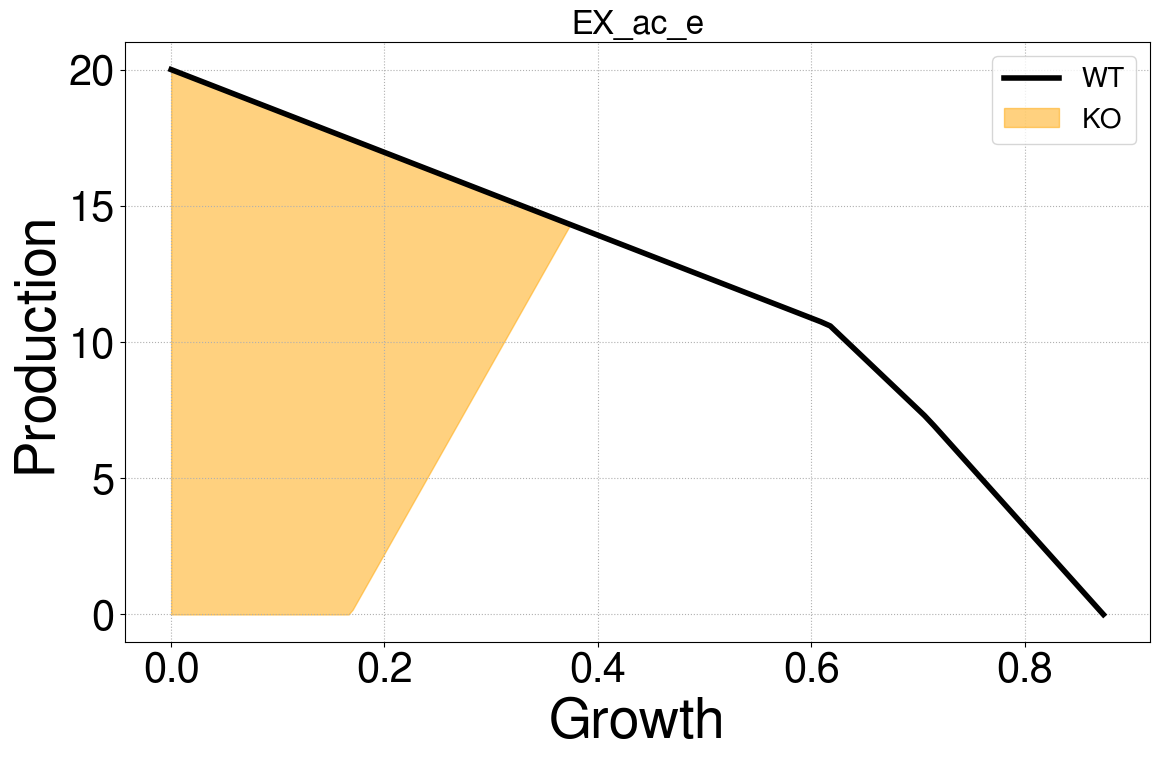


EX_acald_e

EX_akg_e

EX_co2_e
	 success, production = 30.85477706392387


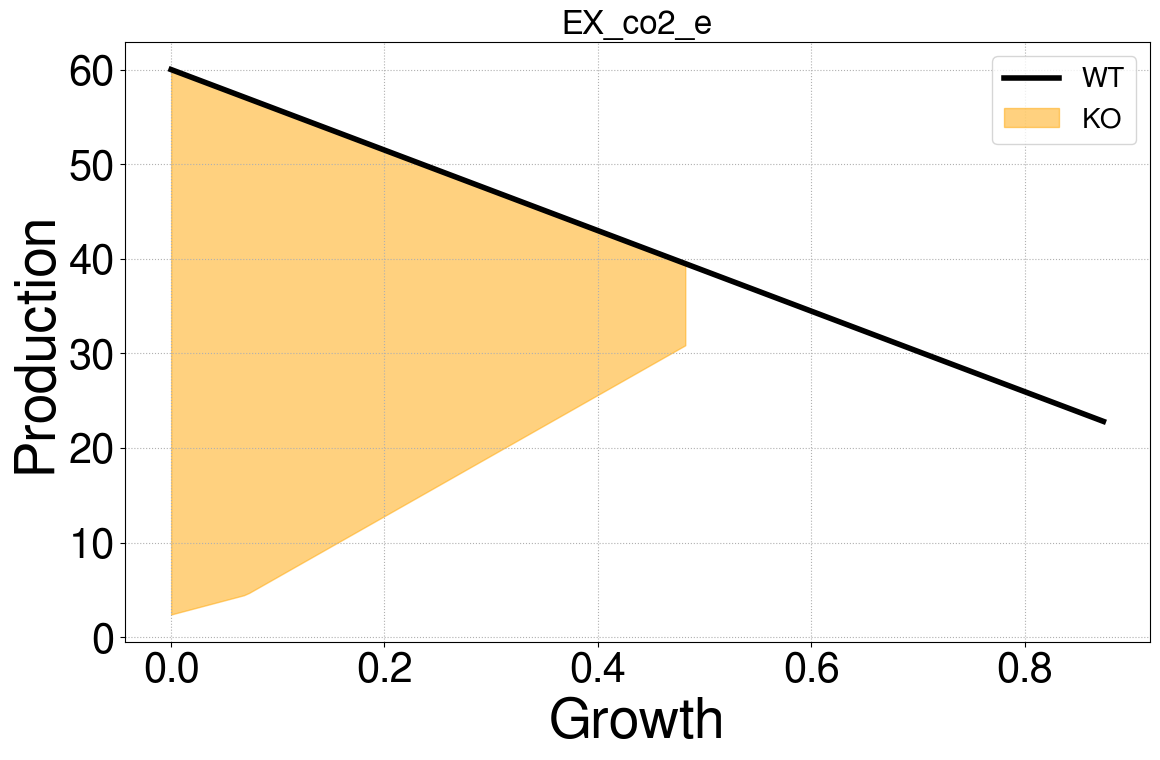


EX_etoh_e
	 success, production = 14.196174728389222


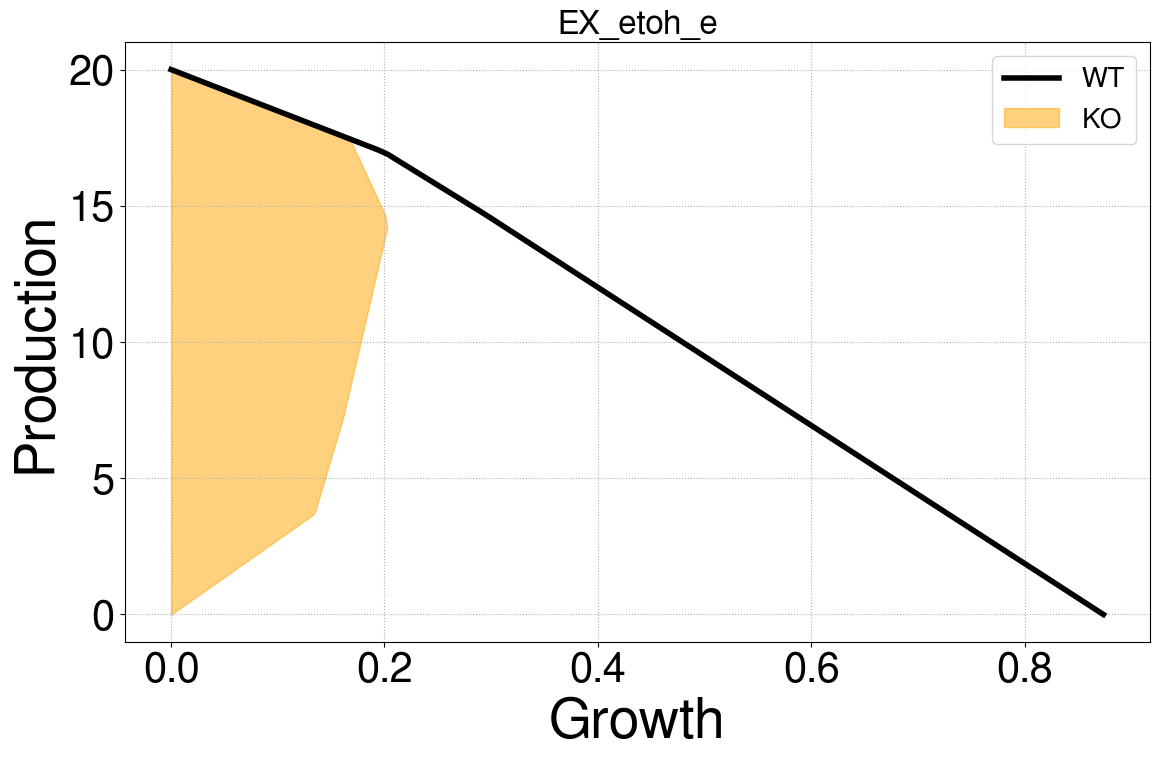


EX_for_e
	 success, production = 23.472310250111853


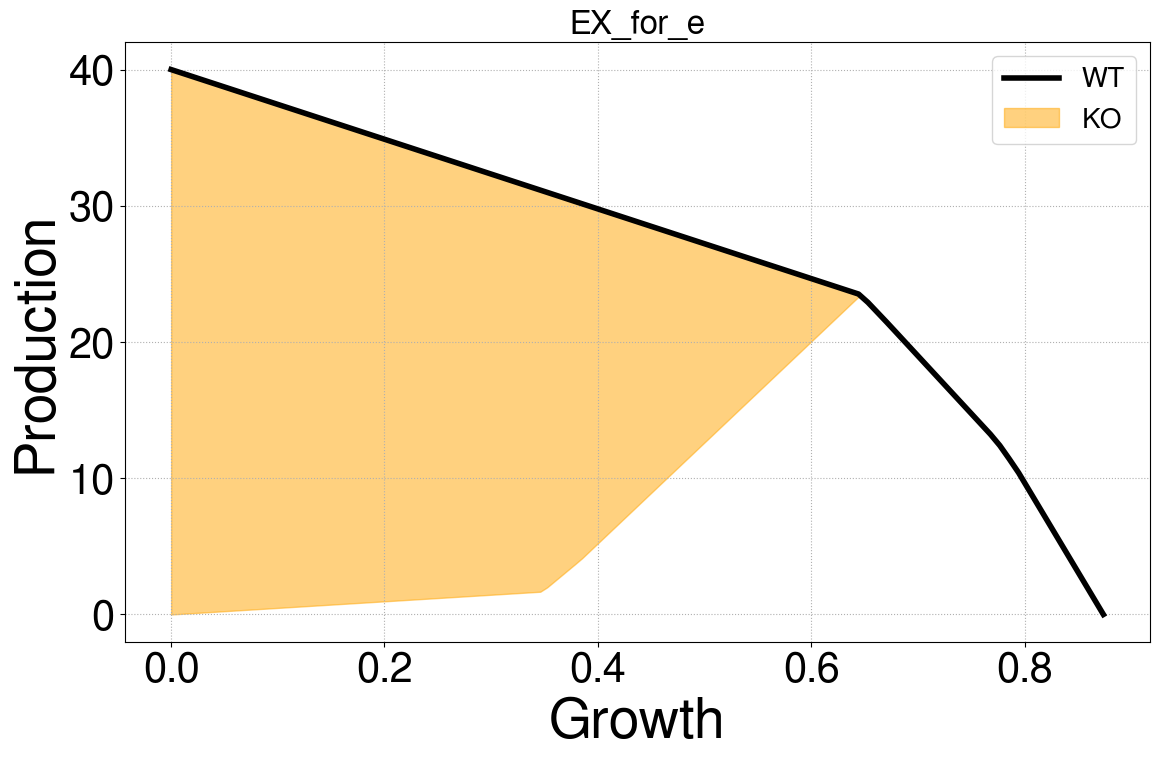


EX_fru_e

EX_fum_e

EX_glc__D_e

EX_gln__L_e

EX_glu__L_e

EX_h_e
	 success, production = 37.9378811201561


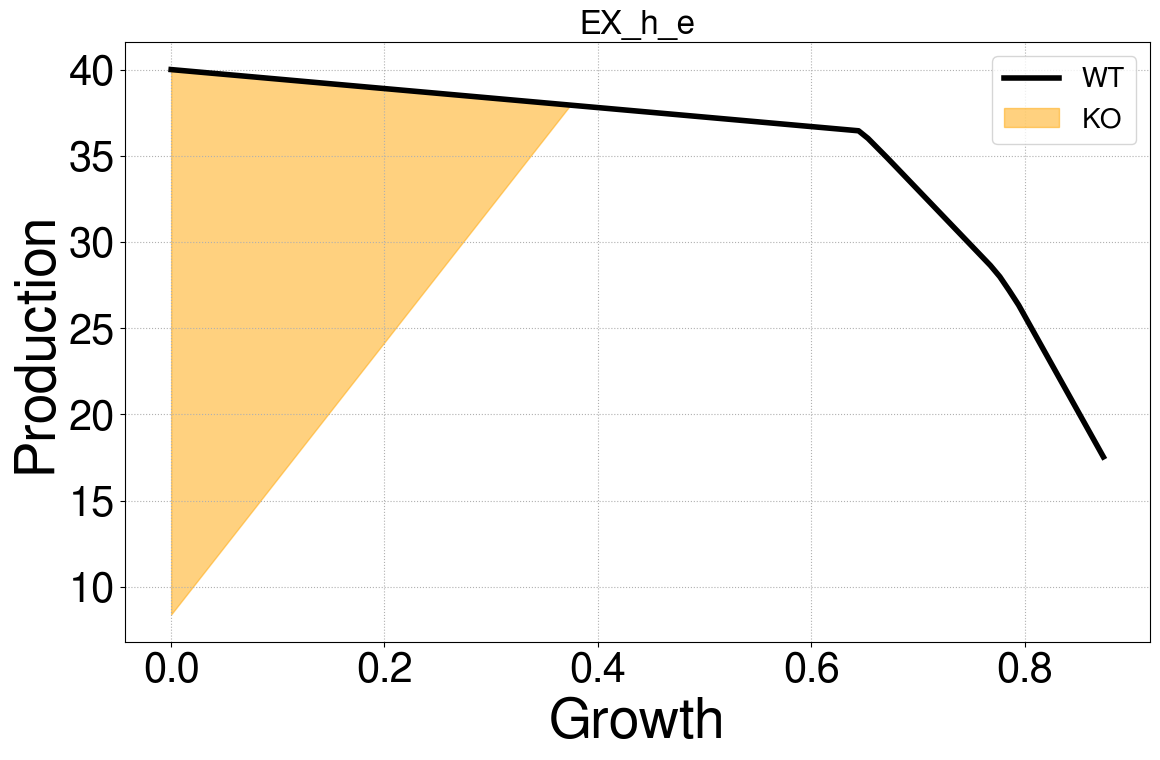


EX_h2o_e
	 success, production = 34.365652758565744


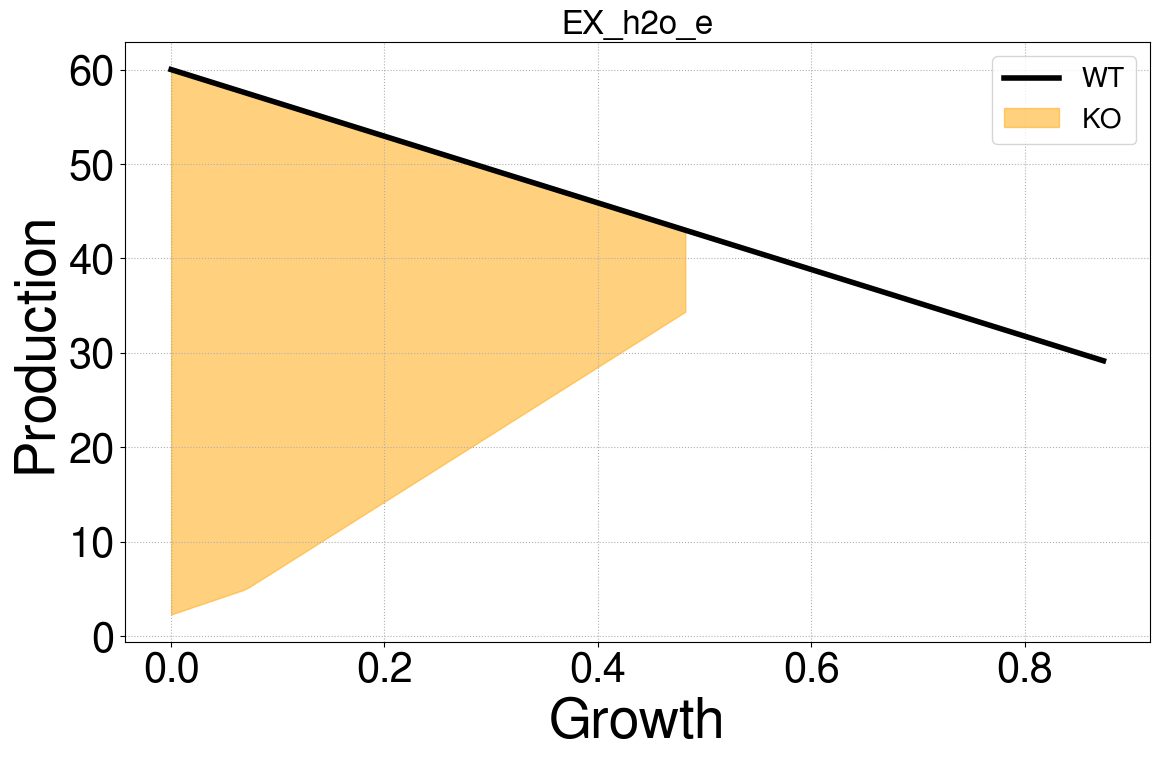


EX_lac__D_e

EX_mal__L_e

EX_nh4_e

EX_o2_e

EX_pi_e

EX_pyr_e

EX_succ_e
	 success, production = 3.818779990708122


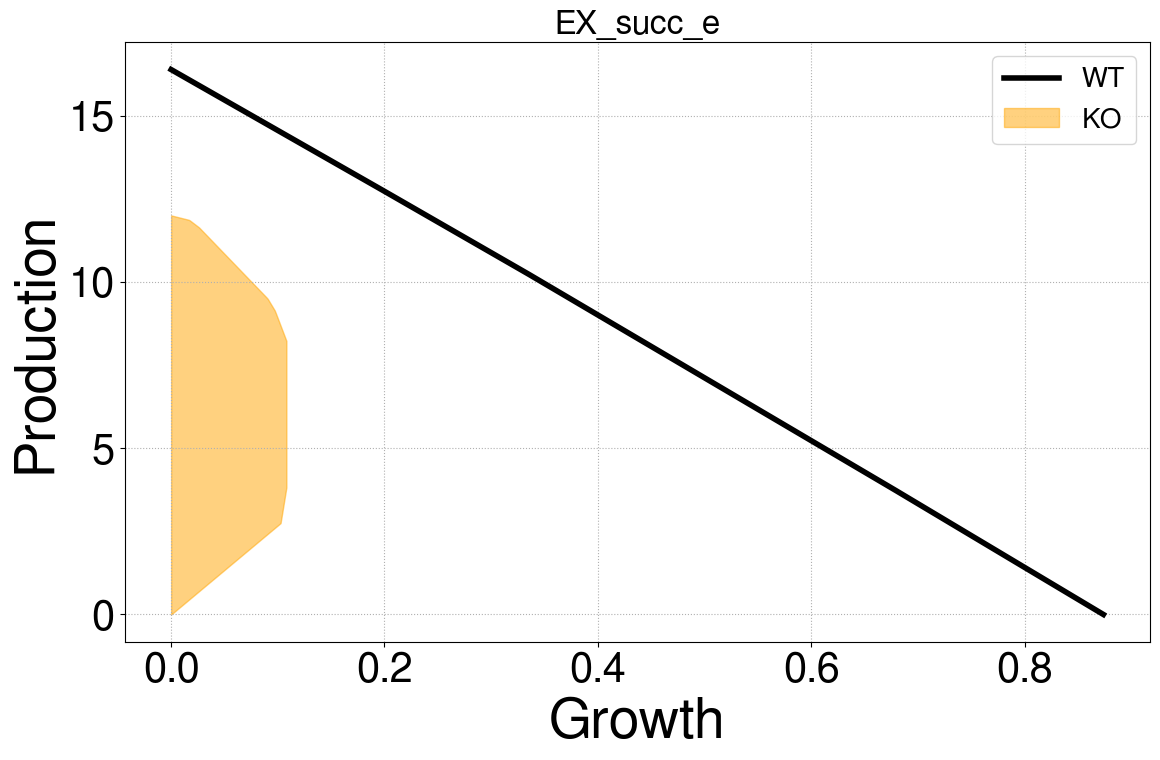


CPU times: user 7min 37s, sys: 21.7 ms, total: 7min 37s
Wall time: 7min 38s


In [11]:
%%time 

biomass_reaction_label = 'Biomass_Ecoli_core'
number_of_genes = len(model.genes)

for reaction in model.reactions:
    reactionID = reaction.id
    if 'EX_' in reactionID:
        print(reactionID)
        #reactionID='EX_for_e'
    
        results = []
        for i in range(len(model.genes)):
            for j in range(len(model.genes)):
                if i < j:

                    task = [i, j, reactionID, biomass_reaction_label, model]
                    result = growth_coupled_analysis(task)
                    results.append(result)         
        df = pandas.DataFrame(results, columns=['i', 'j', 'KO growth', 'min production', 'max production'])
        df.sort_values(by=['min production'], ascending=False, inplace=True)
        production = df.iloc[0, :]['min production']
        if production > 1:
            print('\t success, production = {}'.format(production))
            
            # make the envelope plot
            # WT
            plotting_wt_biomass = []
            wt_production = []

            biomass_space = numpy.linspace(0, wt_solution.objective_value, 100)

            with model as model:
                model.objective = reactionID
                for target in biomass_space:
                    model.reactions.get_by_id(biomass_reaction_label).bounds = (target, target)
                    solution = model.optimize()
                    if solution.status == 'optimal':
                        plotting_wt_biomass.append(target); wt_production.append(solution.objective_value)
                        
            # KO
            i=int(df.iloc[0, :]['i']); j=int(df.iloc[0, :]['j'])

            plotting_ko_biomass = []
            max_productions = []
            min_productions = []

            with model as model:
                model.genes[i].knock_out() 
                model.genes[j].knock_out()
                ko_solution = model.optimize()

                biomass_space = numpy.linspace(0, ko_solution.objective_value, 100)
                with model as model:
                    model.objective = reactionID
                    for target in biomass_space:
                        model.reactions.get_by_id(biomass_reaction_label).lower_bound = target
                        max_production = model.optimize(objective_sense='maximize').objective_value
                        min_production = model.optimize(objective_sense='minimize').objective_value
                        plotting_ko_biomass.append(target); max_productions.append(max_production); min_productions.append(min_production)
                        
            # make figure
            matplotlib.pyplot.plot(plotting_wt_biomass, wt_production, '-', color='black', lw=4, label='WT')
            matplotlib.pyplot.fill_between(plotting_ko_biomass, min_productions, max_productions, color='orange', alpha=0.5, label='KO')

            matplotlib.pyplot.xlabel('Growth')
            matplotlib.pyplot.ylabel('Production')
            matplotlib.pyplot.title(reactionID)
            matplotlib.pyplot.grid(ls=':')
            matplotlib.pyplot.legend()

            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.show()
            
        print()
        
        

In [12]:
df

,i,j,KO growth,min production,max production
283,2,15,1.080224e-01,3.818780e+00,8.227463e+00
288,2,20,1.080224e-01,3.818780e+00,8.227463e+00
289,2,21,1.080224e-01,3.818780e+00,8.227463e+00
290,2,22,1.080224e-01,3.818780e+00,8.227463e+00
286,2,18,1.080224e-01,3.818780e+00,8.227463e+00
...,...,...,...,...,...
8955,109,127,6.170374e-01,-2.093203e-15,-1.634581e-14
8954,109,126,6.170374e-01,-2.491908e-15,-2.847334e-14
7094,69,126,6.170374e-01,-2.491908e-15,-2.847334e-14
5819,52,126,6.170374e-01,-2.491908e-15,-2.847334e-14


In [14]:
# make the envelope plot
            # WT
            plotting_wt_biomass = []
            wt_production = []

            biomass_space = numpy.linspace(0, wt_solution.objective_value, 100)

            with model as model:
                model.objective = reactionID
                for target in biomass_space:
                    model.reactions.get_by_id(biomass_reaction_label).bounds = (target, target)
                    solution = model.optimize()
                    if solution.status == 'optimal':
                        plotting_wt_biomass.append(target); wt_production.append(solution.objective_value)
                        
            # KO
            i=int(df.iloc[0, :]['i']); j=int(df.iloc[0, :]['j'])

            plotting_ko_biomass = []
            max_productions = []
            min_productions = []

            with model as model:
                model.genes[i].knock_out() 
                model.genes[j].knock_out()
                ko_solution = model.optimize()

                biomass_space = numpy.linspace(0, ko_solution.objective_value, 100)
                with model as model:
                    model.objective = reactionID
                    for target in biomass_space:
                        model.reactions.get_by_id(biomass_reaction_label).lower_bound = target
                        max_production = model.optimize(objective_sense='maximize').objective_value
                        min_production = model.optimize(objective_sense='minimize').objective_value
                        plotting_ko_biomass.append(target); max_productions.append(max_production); min_productions.append(min_production)
                        
            # make figure
            matplotlib.pyplot.plot(plotting_wt_biomass, wt_production, '-', color='black', lw=4, label='WT')
            matplotlib.pyplot.fill_between(plotting_ko_biomass, min_productions, max_productions, color='orange', alpha=0.5, label='KO')

            matplotlib.pyplot.xlabel('Growth')
            matplotlib.pyplot.ylabel('Production')
            matplotlib.pyplot.title(reactionID)
            matplotlib.pyplot.grid(ls=':')
            matplotlib.pyplot.legend()

            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.clf()
            
        print()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 50)

In [ ]:
this is the end

## 2.2. run serial

In [ ]:
%%time
number_of_genes = len(model.genes)
results = []
for i in range(len(model.genes)):
    for j in range(len(model.genes)):
        if i < j:
            
            task = [i, j, metabolite_of_interest, biomass_reaction_label, model]
            result = growth_coupled_analysis(task)
            results.append(result)         

In [ ]:
df = pandas.DataFrame(results, columns=['i', 'j', 'KO growth', 'min production', 'max production'])

In [ ]:
df.head()

In [ ]:
df.sort_values(by=['min production'], ascending=False)

### 2.2.1. plot production envelope

In [ ]:
# WT
plotting_wt_biomass = []
wt_production = []

biomass_space = numpy.linspace(0, wt_solution.objective_value, 100)

with model as model:
    model.objective = metabolite_of_interest
    for target in biomass_space:
        model.reactions.get_by_id(biomass_reaction_label).bounds = (target, target)
        solution = model.optimize()
        if solution.status == 'optimal':
            plotting_wt_biomass.append(target); wt_production.append(solution.objective_value)

In [ ]:
# KO
i=21; j=126

plotting_ko_biomass = []
max_productions = []
min_productions = []

with model as model:
    model.genes[i].knock_out() 
    model.genes[j].knock_out()
    ko_solution = model.optimize()
    
    biomass_space = numpy.linspace(0, ko_solution.objective_value, 100)
    with model as model:
        model.objective = metabolite_of_interest
        for target in biomass_space:
            model.reactions.get_by_id(biomass_reaction_label).lower_bound = target
            max_production = model.optimize(objective_sense='maximize').objective_value
            min_production = model.optimize(objective_sense='minimize').objective_value
            plotting_ko_biomass.append(target); max_productions.append(max_production); min_productions.append(min_production)

In [ ]:
# make figure
matplotlib.pyplot.plot(plotting_wt_biomass, wt_production, '-', color='black', lw=4, label='WT')
matplotlib.pyplot.fill_between(plotting_ko_biomass, min_productions, max_productions, color='orange', alpha=0.5, label='KO')

matplotlib.pyplot.xlabel('Growth')
matplotlib.pyplot.ylabel('Production')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.legend()

matplotlib.pyplot.tight_layout()

## 2.3. run in parallel environment

Using multiprocessing could be difficult because if the function yields an error, it is difficult to track. Consider using testing functions and serial code as in previous section to avoid errors while executing the parallel approach.

In [ ]:
number_of_threads = 20

In [ ]:
printt('working with {} genes'.format(number_of_genes))

tasks = []
for i in range(len(model.genes)):
    for j in range(len(model.genes)):
        if i < j:
            task = [i, j, metabolite_of_interest, biomass_reaction_label, model]
            tasks.append(task)
printt('working with {} gene pairs'.format(len(tasks)))

In [ ]:
%%time
printt('entering a parallel world of {} threads'.format(number_of_threads))
hydra = multiprocessing.pool.Pool(number_of_threads)
hydra_output = hydra.map(growth_coupled_analysis, tasks)
hydra.close()
printt('completed {} tasks'.format(len(hydra_output)))

In [ ]:
df = pandas.DataFrame(hydra_output, columns=['i', 'j', 'KO growth', 'min production', 'max production'])
df.sort_values(by=['min production'], ascending=False)